In [1]:
# Install necessary packages (for Colab)
!pip install neurodsp

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from neurodsp.sim import sim_powerlaw, sim_cycle, sim_oscillation
from neurodsp.utils import create_times
from neurodsp.filt import filter_signal
from neurodsp.timefrequency import amp_by_time, phase_by_time
from neurodsp.plts import plot_time_series, plot_instantaneous_measure

# Cycle-by-cycle philosophy

Neural signals, like the example shown below, are analyzed in order to extract information about
brain activity. We process these signals in order to extract features that will hopefully
correlate with a behavior, pathology, or something else.

Oscillations are sometimes a prominent feature of these signals. In the spectral domain, analyses
characterize these rhythms in terms of their frequency, power, and phase.

The conventional approach to analyzing these properties as a function of time is to study a
narrowband signal by applying a wavelet transform or bandpass filtering followed by the Hilbert
transform. The latter is demonstrated below.

## Conventional Analysis 

Hilbert Transform: Amplitude & Phase

In [3]:
# Simulation settings
np.random.seed(0)
n_seconds = 5
fs = 1000

# Simulate a dynamic periodic signal
sig_periodic = np.zeros(int(n_seconds * fs))

rdsyms = np.linspace(.1, .9, 50)

for ind in range(len(rdsyms)):

    cyc = sim_cycle(.1, fs, 'asine', rdsym=rdsyms[ind])
    
    sig_periodic[ind*100:(ind*100)+100] = cyc

# Mask signal to make bursty
burst_inds = [(500, 1500), (2500, 3000), (3500, 4500)]

sig_periodic[:500] = 0
sig_periodic[1500:2500] = 0
sig_periodic[3000:3500] = 0
sig_periodic[4500:] = 0

# Simulate aperiodic component
sig_aperiodic = sim_powerlaw(n_seconds, fs, f_range=(2, None), exponent=-2, mean=0, variance=.2)

# Combine signals
sig = sig_periodic + sig_aperiodic


/usr/local/anaconda3/envs/voytek/lib/python3.9/site-packages/neurodsp/sim/utils.py:104: RuntimeWarning: invalid value encountered in reciprocal
  mask = (np.abs(freqs) / f_rotation)**-delta_exponent


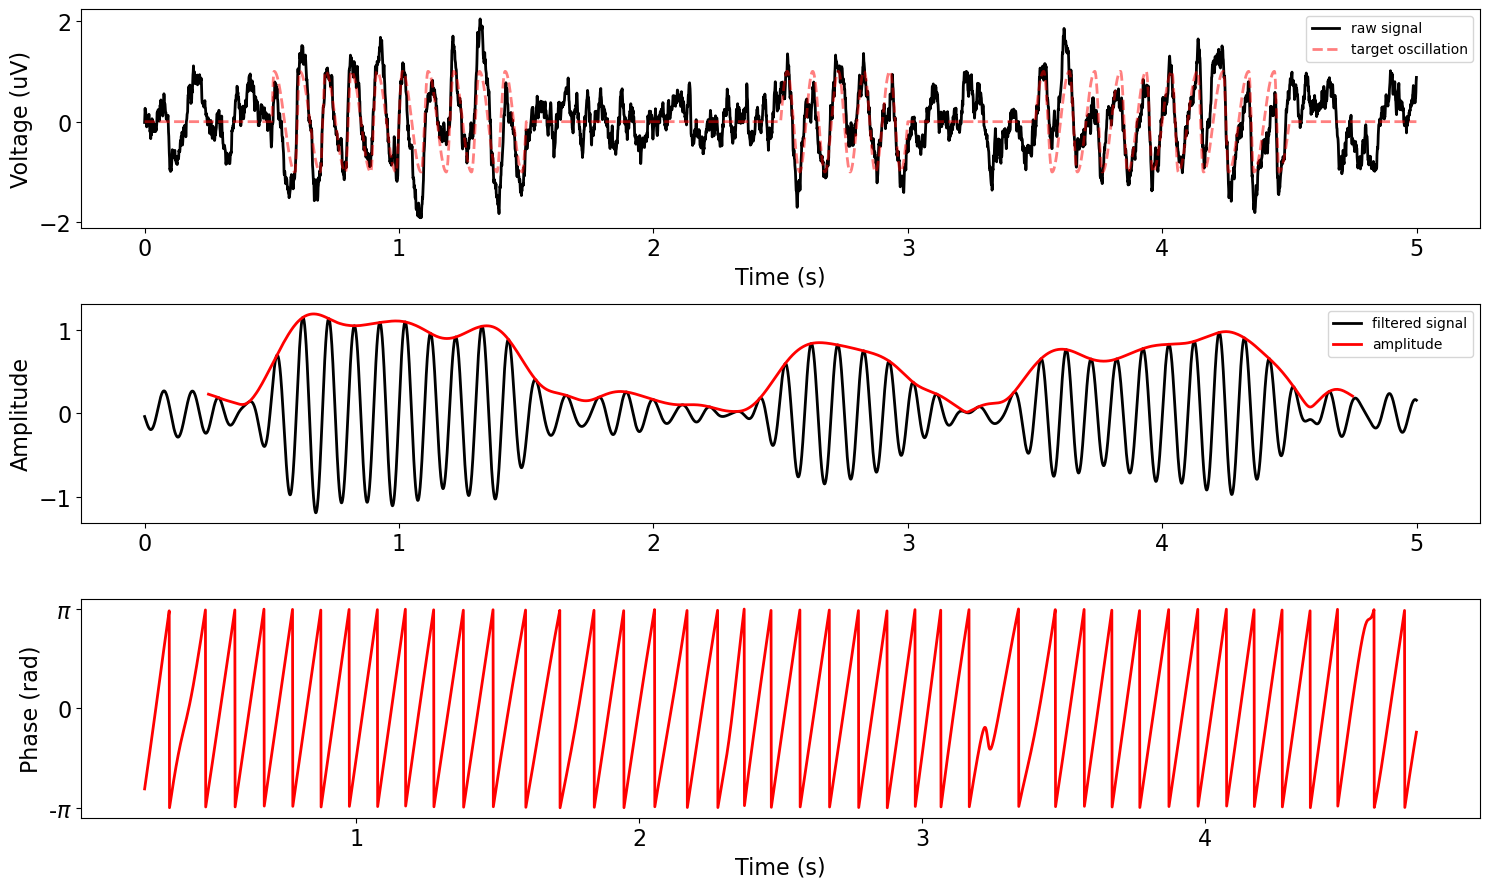

In [4]:
# Filter settings
f_alpha = (8, 12)
n_seconds_filter = .5

# Compute amplitude and phase
sig_filt = filter_signal(sig, fs, 'bandpass', f_alpha, n_seconds=n_seconds_filter, remove_edges=False)
theta_amp = amp_by_time(sig, fs, f_alpha, n_seconds=n_seconds_filter)
theta_phase = phase_by_time(sig, fs, f_alpha, n_seconds=n_seconds_filter)

# Plot signal
fig, axes = plt.subplots(figsize=(15, 9), nrows=3)

# Plot the raw signal
times = create_times(n_seconds, fs)

plot_time_series(times, sig, ax=axes[0], ylabel='Voltage (mV)',
                 xlabel='', lw=2, labels='raw signal')

plot_time_series(times, sig_periodic, ax=axes[0], alpha=.5, ls='--',
                 colors='r', lw=2, labels='target oscillation')

# Plot the filtered signal and oscillation amplitude
plot_instantaneous_measure(times, [sig_filt, theta_amp],
                           ax=axes[1], measure='amplitude', lw=2, xlabel='',
                           labels=['filtered signal', 'amplitude'])

# Plot the phase
plot_instantaneous_measure(times, theta_phase, ax=axes[2], colors='r',
                           measure='phase', lw=2, xlabel='Time (s)')

# Add legends
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right');

## Conventional Analysis Limitations

This conventional analysis has some advantages and disadvantages. As for advantages:

- Quick calculation
- Neat mathematical theory
- Results largely make sense
- Defined at every point in time

Because of this last property, these traces have come to be known as "instantaneous" amplitude and
phase. And they seem to make a lot of sense, when looking at the raw signal.

However, there are some key disadvantages to this analysis that stem from its sine wave basis:

1. Although defined at all samples, amplitude and phase estimates are not interpretable or meaningful in the absence
of oscillations. When non-oscillatory, amplitude and phase are influenced by the other aspects of the signal, such
as random aperiodic fluctuations. This highlights the importance of burst detection. One conventional burst detection
method uses instantaneous amplitude thresholds. Bycycle adds another approach and determines bursts based on how
consistent shape features are across time.

2. This analysis does not capture a potentially important aspect of the data, in that the oscillatory cycles tend to
have short rises and longer decays. This is partly because the signal is filtered in a narrow frequency band (using a
sine wave basis) that cannot accurately reconstruct nonsinusoidal waveforms. Furthermore, this nonsinusoidal feature
will unintuitively bias amplitude and phase estimates (though perhaps negligibly). Furthermore, there are no apparent
tools for extracting nonsinusoidal properties using conventional techniques.

### Parameter Settings

Below demonstrates how the choice of filter length and frequency range affects the instantaneous amplitude, and how these parameters may lead to different burst definitions. When the filter frequency range is on the edge of the oscillatory center frequency, the boundaries between bursts (highlighted in red) becomes less clear. Thus the choice of filter frequency range is important in conventional burst detection methods. Bycycle includes additional waveform shape features for detecting bursts. This provides greater flexibility when tuning burst detection.

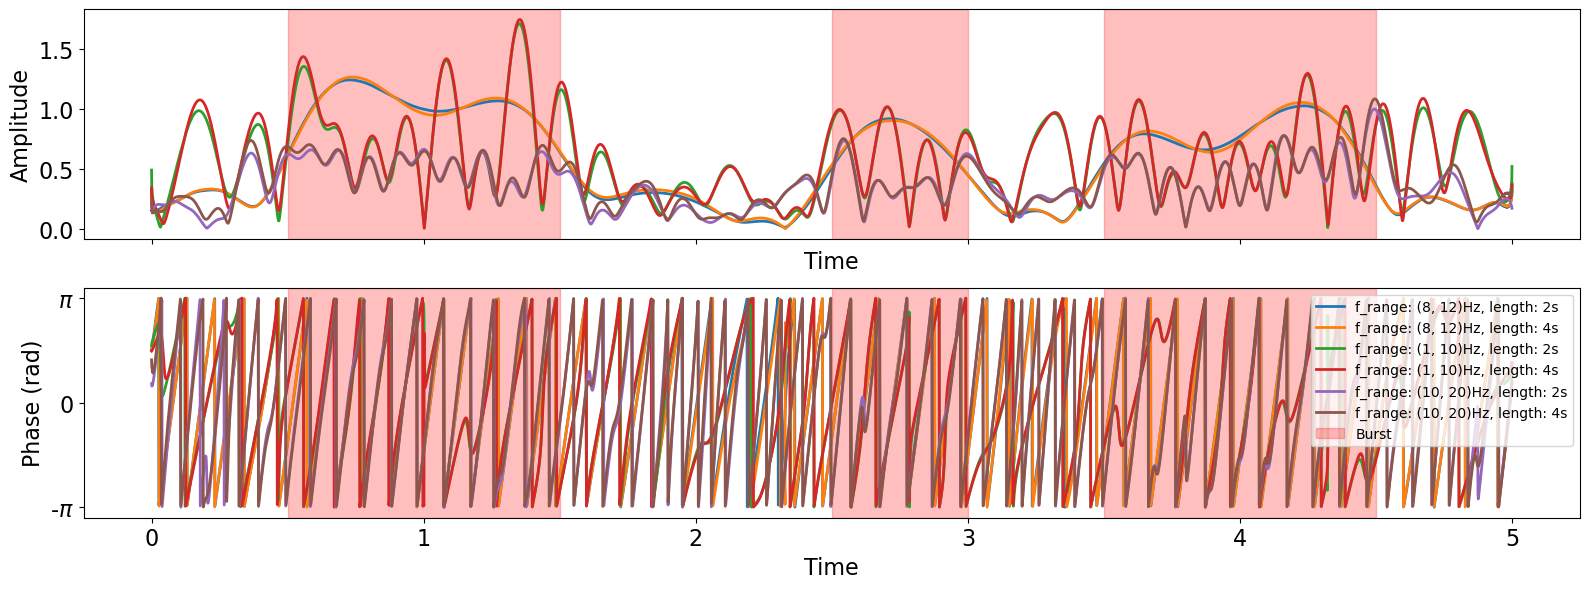

In [5]:
# Different hyperparameter choices - filter length and bandwidth
f_alphas = [(8, 12), (1, 10), (10, 20)]
n_seconds = [2, 4]

amps = []
phases = []

for f_alpha in f_alphas:
    for n_second_filter in n_seconds:
        amp = amp_by_time(sig, fs, f_alpha, n_seconds=n_second_filter, remove_edges=False)
        amps.append(amp)

        pha = phase_by_time(sig, fs, f_alpha, n_seconds=n_second_filter, remove_edges=False)
        phases.append(pha)

# Plot
fig, axes = plt.subplots(figsize=(16, 6), nrows=2, sharex=True)

labels = [f'f_range: {f_range}Hz, length: {filter_len}s'
          for f_range in f_alphas for filter_len in n_seconds]

plot_instantaneous_measure(times, amps, ax=axes[0], measure='amplitude', lw=2, xlabel='Time')
plot_instantaneous_measure(times, phases, ax=axes[1], measure='phase', lw=2,
                           xlabel='Time', labels=labels)

# Shade true bursts
for i, burst in enumerate(burst_inds):
    label = 'Burst' if i == 0 else ''
    axes[0].axvspan(times[burst[0]], times[burst[1]], alpha=0.25, color='red')
    axes[1].axvspan(times[burst[0]], times[burst[1]], alpha=0.25, color='red', label=label)
    
axes[1].legend(loc='upper right');

### Loss of Non-Sinusoidal Features

Below demonstrates how a narrowband filtered signal, which instantaneous amplitude and phase are computed from, results in a loss on non-sinusoidal features. Appropriate narrowband filters are required for conventional burst detection methods. Bycycles uses a narrowband filter to determine the location of cycles (e.g. the time at peaks and troughs), however, shape features are computed from the raw signal provided to `compute_features` preserving non-sinusoidal features.

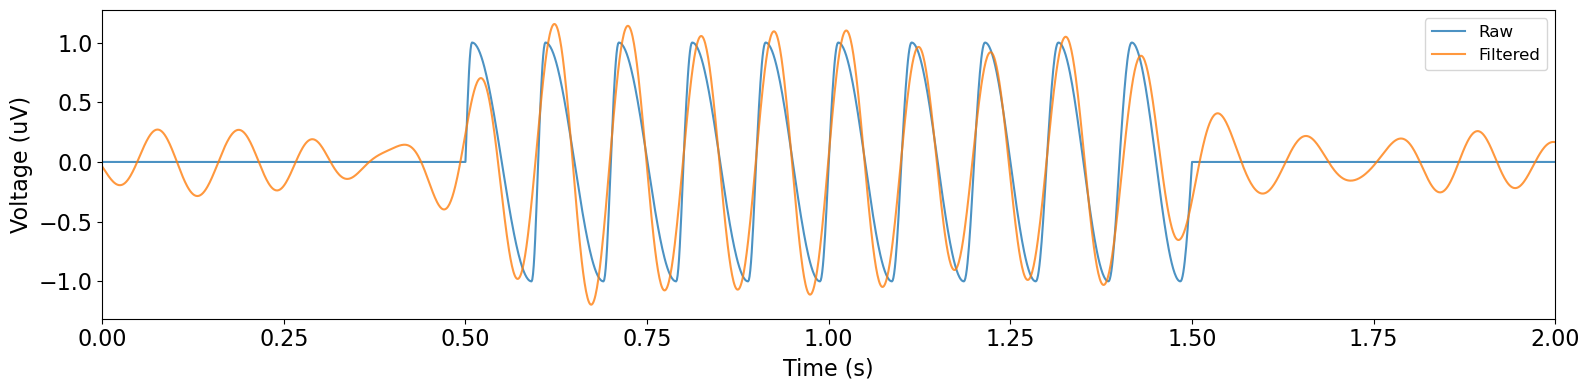

In [6]:
fig, ax = plt.subplots(figsize=(16, 4))

plot_time_series(times, sig_periodic, ax=ax, alpha=.8, colors='C0', xlim=(0, 2), labels='Raw')
plot_time_series(times, sig_filt, ax=ax, colors='C1', alpha=.8, xlim=(0, 2), labels='Filtered')

### False Positive Phase-Amplitude Coupling

Phase-amplitude coupling (PAC) is one type of cross-frequency coupling (CFC), in which a faster oscillation's amplitude is coupled with the phase of a slower oscillation. PAC is an interesting phenomena that many researchers seek to investigate in their study of oscillations and how oscillations support cognitive processes. Conventional PAC analyses can conflate non-sinusoidal waveform shape with PAC, as we will see through simulation below.

First, we simulate an instance of true PAC, in which high gamma oscillation (120 Hz) amplitude is maximized when the slower theta oscillation (6 Hz) is at its trough. We then create a non-sinusoidal waveform with very long/wide peaks and narrow/short troughs. 

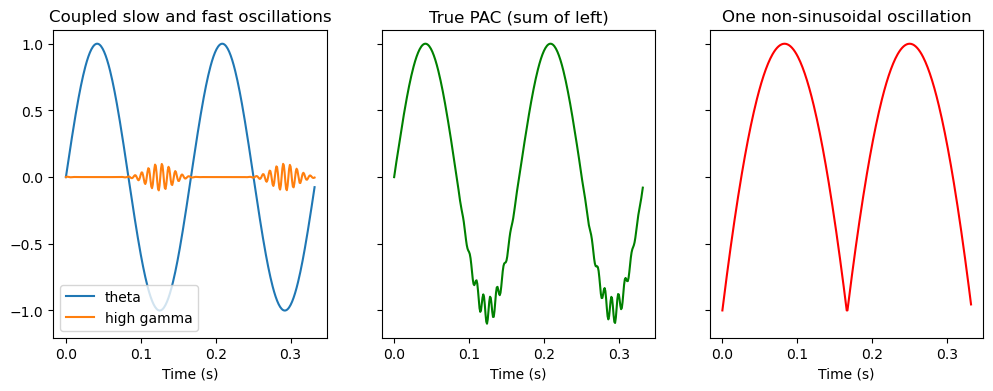

In [7]:
# Set parameters
n_seconds = 5
fs = 1000
slow_freq = 6  # slow oscillation in Hz (theta)
fast_freq = 120  # fast oscillation in Hz (high gamma)
rel_amp = .1  # relative amplitude of the faster oscillation

# Create slow oscillation
slow_osc = sim_oscillation(n_seconds, fs, slow_freq)
slow_osc /= np.max(slow_osc)

# Create fast oscillation
window = sim_oscillation(
    n_seconds, fs, slow_freq, 'gaussian', std=0.1, phase=0.75)
window = (window - np.min(window)) / (np.max(window) - np.min(window))
fast_osc = window * sim_oscillation(n_seconds, fs, fast_freq)
fast_osc /= (np.max(fast_osc) / rel_amp)

# Sum together to create composite signal
tp_pac = slow_osc + fast_osc

# Create Gaussian oscillation with same frequency as theta
fp_pac = sim_oscillation(n_seconds, fs, slow_freq, cycle='gaussian', std=1)
fp_pac = (fp_pac - np.min(fp_pac)) / (np.max(fp_pac) - np.min(fp_pac))
fp_pac = (fp_pac - 0.5) * 2

# Make time vector
times = create_times(n_seconds, fs)

# Plot true positive and false positive PAC
two_cycles = int(2*fs/slow_freq)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
axes[0].plot(times[:two_cycles], slow_osc[:two_cycles], label='theta')
axes[0].plot(times[:two_cycles], fast_osc[:two_cycles], label='high gamma')
axes[0].set_title('Coupled slow and fast oscillations')
axes[0].set_xlabel('Time (s)')
axes[0].legend()

axes[1].plot(times[:two_cycles], tp_pac[:two_cycles], c='g')
axes[1].set_title('True PAC (sum of left)')
axes[1].set_xlabel('Time (s)')

axes[2].plot(times[:two_cycles], fp_pac[:two_cycles], c='r')
axes[2].set_title('One non-sinusoidal oscillation')
axes[2].set_xlabel('Time (s)')
plt.show()

The plot above should make it quite apparent that these are two *very* different signals, and we would expect the physiological mechanisms underpinning each of them to be very different. 

PAC is often used to support the theory of communication through coherence (CTC, see [Fries, 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4605134/)), casting PAC as evidence that oscillations are a means by which distinct brain areas can communicate with each other. Sharp waveforms, on the other hand, are thought to be evidence of synchrony in the underlying neural populations (see [Sherman et al., 2016](https://www.pnas.org/doi/10.1073/pnas.1604135113)). These are two very different theories about what is occurring in the underlying physiology that is giving rise to the neural data we are recording, **and it is important that we resolve which of these cases we are in if we are to make headway**. 

Next, we take these two signals as see whether we can find evidence of PAC in either of them.

In [8]:
def calculate_pac(
        dat, phase_band, amplitude_band, title, ax=None, bin_size=5, 
        bin_scalar=0.0174532925):
    """Function for calculating and plotting PAC."""
    # Isolate the slow component
    phase_data_filt = filter_signal(
        dat, fs, 'bandpass', phase_band, n_cycles=2, remove_edges=False)
    
    #isolate the fast component
    amp_data_filt = filter_signal(
        dat, fs, 'bandpass', amplitude_band,n_cycles=2, remove_edges=False)
    
    # Calculate phase angle of slow component
    phase_data = np.angle(hilbert(phase_data_filt))
    
    # Calculate amplitude envelope of fast component
    amp_data = abs(hilbert(amp_data_filt))
    
    # Make bins
    bins = range(-180,180+bin_size,bin_size) 
    bins = np.dot(bins, bin_scalar)
    
    # Fill phase bins with amplitudes
    amps = []
    for x in range(len(bins)-1):
        amps_above_lo_bound = np.where(phase_data >= bins[x])[0]
        amps_below_hi_bound = np.where(phase_data < bins[x+1])[0]
        amps_below_hi_bound = set(amps_below_hi_bound)
        amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if \
                                amp_val in amps_below_hi_bound]
        amps_in_this_bin = amp_data[amp_inds_in_this_bin]
        amps.append(np.mean(amps_in_this_bin))
    bins = bins[:len(bins)-1]

    # Normalize to make the effect more clear
    amps = (amps-np.mean(amps))/(np.std(amps))
    
    # Make figure
    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
    ax.bar(bins, amps, width=bins[1]-bins[0])
    ax.set_title(title, size=15)
    ax.set_ylim(bottom=0)

With a function to calculate and plot PAC, now we just need to feed it our two signals.

/usr/local/anaconda3/envs/voytek/lib/python3.9/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is 48.2 Hz. This is greater than the desired pass/stop bandwidth of 40.0 Hz
  warn('Transition bandwidth is {:.1f} Hz. This is greater than the desired '\


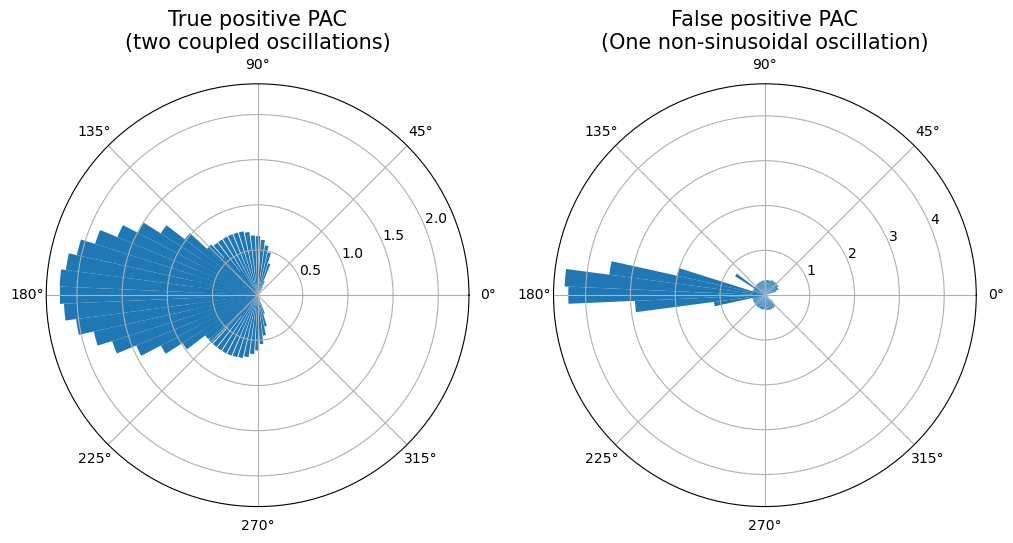

In [9]:
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122, projection='polar')
calculate_pac(
    tp_pac, (slow_freq-2, slow_freq+2), (fast_freq-20, fast_freq+20), 
    'True positive PAC\n(two coupled oscillations)', ax=ax1)
calculate_pac(
    fp_pac, (slow_freq-2, slow_freq+2), (fast_freq-20, fast_freq+20), 
    'False positive PAC\n(One non-sinusoidal oscillation)', ax=ax2)

In both cases, with two coupled oscillations and with one non-sinusoidal oscillation, there is higher amplitude in the gamma-filtered signal at the trough of the theta-filtered signal. Thus, **we cannot adjucate between these two situations through conventional PAC analysis alone, and it is vital that the time series be examined** to determine whether the indicated PAC is because of two coupled oscillation or one non-sinusoidal oscillation.

This does not mean that PAC is always artifactual; one just needs to be more thorough before claiming that PAC is occurring in one's data.